['testing/kernel-explorer\\rq\\aniso=[1.0000,1.0000,1.0000]-s=1.000-l=0.300-a=0.250\\32-grid-samples-fs.bin', 'testing/kernel-explorer\\rq\\aniso=[1.0000,1.0000,1.0000]-s=1.000-l=0.300-a=1.000\\32-grid-samples-fs.bin', 'testing/kernel-explorer\\se\\aniso=[1.0000,1.0000,1.0000]-s=1.000-l=0.300\\32-grid-samples-fs.bin']


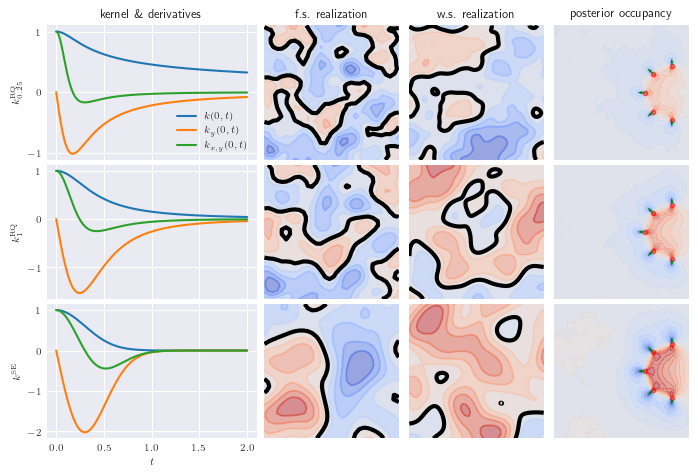

In [85]:
import os
import utils
import glob
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import scipy.interpolate as interp


def plot_posterior(file, ax_occupancy, ax_surface_density):
    realizations = np.fromfile(file.replace("grid-samples-fs", "grid-samples-cond"), dtype=np.float64)
    res = int(np.sqrt(realizations.shape[0]/2000))
    realizations= np.reshape(realizations, (2000, res, res))
    realizations = realizations.transpose(0, 2, 1)

    cond_ps_file = file.replace("grid-samples-fs", "cond-ps-cond")
    if os.path.exists(cond_ps_file):
        cond_ps = np.reshape(np.fromfile(cond_ps_file, dtype=np.float64), (-1, 3))
        cond_ns = np.reshape(np.fromfile(file.replace("grid-samples-fs", "cond-ns-cond"), dtype=np.float64), (-1, 3))
        cond_ds = np.reshape(np.fromfile(file.replace("grid-samples-fs", "cond-ds-cond"), dtype=np.uint8), (-1, 1))
        cond_vs = np.reshape(np.fromfile(file.replace("grid-samples-fs", "cond-vs-cond"), dtype=np.float64), (-1, 1))
    else:
        cond_ps = None

    xs = np.linspace(-1, 1, realizations.shape[1])
    ys = np.linspace(-1, 1, realizations.shape[2])
    xx, yy = np.meshgrid(xs,ys)

    grid_interp = interp.RegularGridInterpolator((xs, ys), realizations.transpose(2, 1, 0))
    hd_xs = np.linspace(-1, 1, 100)
    hd_ys = np.linspace(-1, 1, 100)
    hd_xx, hd_yy = np.meshgrid(hd_xs,hd_ys)

    interp_reals = np.atleast_2d(grid_interp((hd_xx, hd_yy)))

    if ax_occupancy is not None:
        occupancy = np.mean(interp_reals < 0, axis=2)
        ax_occupancy.contourf(hd_xx, hd_yy, occupancy, vmin=0, vmax=1, alpha=0.5, levels = np.linspace(0, 1, 21), cmap="coolwarm")
        #ax_occupancy.set_title("Occupancy ($P(f(x) < 0)$)")
        ax_occupancy.set_xticks([])
        ax_occupancy.set_yticks([])
        ax_occupancy.set_aspect("equal")

    if ax_surface_density is not None:
        surface_density = np.mean(np.abs(interp_reals) < 0.01, axis=2)
        cs = ax_surface_density.contourf(hd_xx, hd_yy, surface_density, vmin=0, vmax=1, alpha=0.5, levels = np.linspace(0, 1, 21), cmap="coolwarm")
        #ax_surface_density.set_title("Surface density ($p(f(x) = 0)$)")
        ax_surface_density.set_xticks([])
        ax_surface_density.set_yticks([])
        ax_surface_density.set_aspect("equal")

    if cond_ps is not None:
        is_fo = (cond_ds == 0).flatten()
        if ax_occupancy:
            ax_occupancy.scatter(cond_ps[is_fo,0], cond_ps[is_fo,1], color="red", s=10, zorder=10, alpha=0.5)
        
        if ax_surface_density:
            ax_surface_density.scatter(cond_ps[is_fo,0], cond_ps[is_fo,1], color="red", s=10, zorder=10, alpha=0.5)

        is_so = ~is_fo
        if np.any(is_so):
            if ax_occupancy:
                ax_occupancy.quiver(
                    cond_ps[is_so,0], cond_ps[is_so,1], 
                    cond_ns[is_so, 0] * cond_vs[is_so, 0], cond_ns[is_so, 1] * cond_vs[is_so, 0], 
                    color="green", zorder=10, alpha=1)
            if ax_surface_density:
                ax_surface_density.quiver(
                    cond_ps[is_so,0], cond_ps[is_so,1], 
                    cond_ns[is_so, 0] * cond_vs[is_so, 0], cond_ns[is_so, 1] * cond_vs[is_so, 0], 
                    color="green", zorder=10, alpha=1)
                
def plot_prior(file, ax_real):
    realizations = np.fromfile(file, dtype=np.float64)
    res = int(np.sqrt(realizations.shape[0]/1))
    realizations= np.reshape(realizations, (1, res, res))
    realizations = realizations.transpose(0, 2, 1)

    utils.plot_realization(realizations[0], ax_real, np.linspace(-1,1,res), np.linspace(-1,1,res))
    ax_real.set_xticks([])
    ax_real.set_yticks([])

def plot_kernel(file, ax_kernel):
    kernel = np.fromfile(file.replace("32-grid-samples-fs", "kernel"), dtype=np.float64)
    kernel_dx = np.fromfile(file.replace("32-grid-samples-fs", "kernel-dx"), dtype=np.float64)
    kernel_dxdy = np.fromfile(file.replace("32-grid-samples-fs", "kernel-dxdy"), dtype=np.float64)

    ts = np.linspace(0, 2, kernel.shape[0])
    ax_kernel.grid()
    ax_kernel.plot(ts, kernel, label="$k(0,t)$")
    ax_kernel.plot(ts, kernel_dx, label="$k_y(0,t)$")
    ax_kernel.plot(ts, kernel_dxdy/kernel_dxdy[0], label="$k_{x,y}(0,t)$")

kernels = list(glob.glob("testing/kernel-explorer/*/*/32-grid-samples-fs.bin"))

kernels = [k for k in kernels if "rq" in k or "se" in k]

print(kernels)

with plt.style.context("seaborn-v0_8-dark"):
    params = {'text.usetex' : True,
            'font.size' : 7,
            'font.family' : 'Linux Libertine'}
    plt.rcParams.update(params)
        
    fig, axs = plt.subplots(len(kernels), 4, figsize=(7, len(kernels)*7/4.5), width_ratios=[1.5, 1, 1, 1], sharex="col")

    for i, kernel in enumerate(kernels):
        with open(kernel.replace("32-grid-samples-fs.bin", "label.txt")) as f:
            axs[i][0].set_ylabel(f.readlines()[0].replace("(", "{").replace(")", "}"))
        
        plot_kernel(kernel, axs[i][0])
        if i == 0:
            axs[i][0].legend()
            axs[i][0].set_title("kernel \& derivatives")
            axs[i][1].set_title("f.s. realization")
            axs[i][2].set_title("w.s. realization")
            axs[i][3].set_title("posterior occupancy")

        if i == len(kernels)-1:
            axs[i][0].set_xlabel("$t$")

        plot_prior(kernel.replace("grid-samples-fs", "grid-samples-fs"), axs[i][1])
        if(os.path.exists(kernel.replace("grid-samples-fs", "grid-samples-ws"))):
            plot_prior(kernel.replace("grid-samples-fs", "grid-samples-ws"), axs[i][2])
        else:
            axs[i][2].set_xlim(-1,1)
            axs[i][2].set_ylim(-1,1)
            axs[i][2].set_xticks([])
            axs[i][2].set_yticks([])
            axs[i][2].text(0,0,'non-stationary',
                ha='center', va='center')
            axs[i][2].patch.set_edgecolor('red')
            axs[i][2].patch.set_linewidth(1)  
        
        if(os.path.exists(kernel.replace("grid-samples-fs", "grid-samples-cond"))):
            plot_posterior(kernel, axs[i][3], None)

    fig.tight_layout(pad=0.5)
    #fig.subplots_adjust(wspace=0.05, hspace=0.05)
    fig.savefig("figures/kernel-explorer.pdf", bbox_inches='tight',pad_inches = 0, dpi = 300)
